In [1]:
import os
import path 
import numpy as np
import pandas as pd
import re
import torch
import collections
import random
import gffpandas.gffpandas as gffpd
import random
from Bio.Seq import Seq

import scipy
import scipy.stats
import matplotlib.pyplot as plt
directory = os.getcwd()
folders = os.listdir(directory)

In [2]:
genomes = [name for name in os.listdir("post_processed_data/")]
genomes.remove('.DS_Store')
sorted_genomes = sorted(genomes)


In [3]:
len(sorted_genomes)

4288

In [4]:
random.seed(5)
torch.manual_seed(5)
train_x = np.array([])
train_y = np.array([])
test_x = np.array([])
test_y = np.array([])

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def read_fasta(dir_name, genome_name, file_name):
    #'sampled_genomes_resampled/'
    f=open(str(dir_name) + '/' + str(genome_name) + '/' + file_name,'r')
    lines=f.readlines()

    hre=re.compile('>(\S+)')
    lre=re.compile('^(\S+)$')

    gene={}

    for line in lines:
            outh = hre.search(line)
            if outh:
                    id=outh.group(1)
            else:
                    outl=lre.search(line)
                    if(id in gene.keys()):
                            gene[id] += outl.group(1)
                    else:
                            gene[id]  =outl.group(1)
    return list(gene.values())

def create_csv(dir_name, genome, coding_seqs, sampled_noncoding_seqs):
    num_coding_seqs = len(coding_seqs)
    num_noncoding_seqs = len(sampled_noncoding_seqs)
    coding_indices = np.arange(0, num_coding_seqs, 1)
    coding_groundtruth = np.arange(0, num_coding_seqs, 1)
    coding_train = ['train'] * num_coding_seqs
    noncoding_indices = np.arange(0, num_noncoding_seqs, 1)
    noncoding_test = ['test'] * num_noncoding_seqs
    noncoding_groundtruth = np.arange(0, num_noncoding_seqs, 1)
    
    data = {'sequence': coding_seqs, 'target': coding_groundtruth, 'set': coding_train, 'validation': [np.nan] * num_coding_seqs}
    coding_df = pd.DataFrame(data, index=coding_indices)
    coding_df.to_csv(dir_name + '/' + genome + '/debug_coding_train.csv')
    
    data = {'sequence': sampled_noncoding_seqs, 'target': noncoding_groundtruth, 'set': noncoding_test, 'validation': [np.nan] * num_noncoding_seqs}
    noncoding_df = pd.DataFrame(data, index=noncoding_indices)
    noncoding_df.to_csv(dir_name + '/' + genome + '/debug_noncoding_test.csv')
    
def find_first_index(lst, target):
    """
    Finds the index of the first matching element in the given list.
    If no match is found, returns -1.
    """
    for i, item in enumerate(lst):
        if item == target:
            return i
    return -1

    
def create_dict(lst):
    result = {element: [] for element in lst}
    return result

def filter_duplicate_subdirectories(directories):
    """
    Returns a dictionary where the keys are directory names and the values are lists of subdirectories,
    filtered to exclude duplicates except for the first encounter of each subdirectory name
    in the order of directories sorted in lexicographic order.
    """
    filtered_directory_indices = create_dict(directories.keys())
    filtered_directory_genes = create_dict(directories.keys())
    subdirectory_set = set()
    for directory_name in sorted(directories.keys()):
        for i in range(len(directories[directory_name])):
            if not directories[directory_name][i] in subdirectory_set:
                filtered_directory_indices[directory_name].append(i)
                filtered_directory_genes[directory_name].append(directories[directory_name][i])
                subdirectory_set.add(directories[directory_name][i])
            else:
                continue
    return filtered_directory_genes

    

In [5]:
genome = 'GCF_000021565.1_ASM2156v1'
sequences = read_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'short.fasta')



In [6]:
sequences

['MECFNGNEWLKKSLEEIFTPPRENWDELRLWVYRFGDDWDIFLIELTIPKLLEEMSEK',
 'MENSWWELAGIIFFSFMVITVALIWGLAIKASYNEEKQKKEEKQQ',
 'MSVADIVILSLLVGGSVFYLYKKFRKDIQKGKCASCPVYGECESEKKV',
 'MSIEQQVLEAMQKAGKPLRSGEIAELTGLDKKEVEKAIKKLKKEGKIESPKRCYYAPSG',
 'MPEKVKDHLSNKKRKRTSGFLARKRTKSGRKILARRRRKGRKRIAIS',
 'MNETVELIFTVVIFLLAVIVIVGLMVYWSKNNTVVDERDRKYYQKDKNDDINH',
 'MPREIITLACTECKRKNYTTTKNKRKHTDRLELRKYCKFCRKHTLHREIK',
 'MGLYDRDYMRERGKRPSPYKTDENKKLIIIAVISFILGFIAGKII',
 'MRIKVKLVRGLAGKRKDQIKAVRSLGLKKVNDERILEKNPMVLGNINKVKHLIQVEEVE',
 'MKVRSSVKKRCEKCRIIKRNGRIMVICENPRHKQKQG']

# loading sampled data

In [9]:
random.seed(5)
torch.manual_seed(5)
coding_genes = []
noncoding_genes = []
positive_genomes = {}
negative_genomes = {}
for genome in genomes:
    # adding a length constraint
    length_upper_limit = 60
    length_lower_limit = 0
#     positive_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/post_processed_data/' + genome + '/coding_train.csv')['sequence'])
#     negative_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/post_processed_data/' + genome + '/noncoding_test.csv')['sequence'])
    positive_testing_sequences = list(pd.read_csv('post_processed_data/' + genome + '/coding_train.csv')['sequence'])
    negative_testing_sequences = list(pd.read_csv('post_processed_data/' + genome + '/noncoding_test.csv')['sequence'])
    positive_testing_sequences = [positive_testing_sequence for positive_testing_sequence in positive_testing_sequences if len(positive_testing_sequence) < 60]
    negative_testing_sequences = [negative_testing_sequence for negative_testing_sequence in negative_testing_sequences if len(negative_testing_sequence) < 60]
    coding_genes.extend(positive_testing_sequences)
    noncoding_genes.extend(negative_testing_sequences)
    
    positive_genomes[genome] = positive_testing_sequences
    negative_genomes[genome] = negative_testing_sequences
    

In [10]:
print('In total, there are ' + str(len(coding_genes)) + ' coding regions, out of which ' + str(len(set(coding_genes))) + ' are unique.')
print('In total, there are ' + str(len(noncoding_genes)) + ' noncoding regions, out of which ' + str(len(set(noncoding_genes))) + ' are unique.')


In total, there are 145232 coding regions, out of which 128615 are unique.
In total, there are 145231 noncoding regions, out of which 143362 are unique.


In [11]:
import collections
result = collections.Counter(coding_genes) & collections.Counter(noncoding_genes)
intersected_list = list(result.elements())
print(len(intersected_list))
print(len(set(intersected_list)))

39
38


In [12]:
#removing these from all datasets
unique_intersected_list = set(intersected_list)
for genome in genomes:
    for gene in positive_genomes[genome]:
        if gene in unique_intersected_list:
            positive_genomes[genome].remove(gene)
    for gene in negative_genomes[genome]:
        if gene in unique_intersected_list:
            negative_genomes[genome].remove(gene)

## filtering out sequences which are longer or equal to 60 AAs

In [13]:
for genome in genomes:
    for gene in positive_genomes[genome]:
        if len(gene) >= 60:
            positive_genomes[genome].remove(gene)
    for gene in negative_genomes[genome]:
        if len(gene) >= 60:
            negative_genomes[genome].remove(gene)

### filtering duplicates in lexicographical order

In [14]:
def filter_duplicate_subdirectories(directories):
    """
    Returns a dictionary where the keys are directory names and the values are lists of subdirectories,
    filtered to exclude duplicates except for the first encounter of each subdirectory name
    in the order of directories sorted in lexicographic order.
    """
    filtered_directory_indices = create_dict(directories.keys())
    filtered_directory_genes = create_dict(directories.keys())
    subdirectory_set = set()
    for directory_name in sorted(directories.keys()):
        for i in range(len(directories[directory_name])):
            if not directories[directory_name][i] in subdirectory_set:
                filtered_directory_indices[directory_name].append(i)
                filtered_directory_genes[directory_name].append(directories[directory_name][i])
                subdirectory_set.add(directories[directory_name][i])
            else:
                continue
    return filtered_directory_genes

In [15]:
#running filtering on all genomes
positive_filtered_genes = filter_duplicate_subdirectories(positive_genomes)
negative_filtered_genes = filter_duplicate_subdirectories(negative_genomes)

In [16]:
#sanity check that there are no duplicates and no shared elements in coding regions and noncoding regions
print('There are ' + str(len(collections.Counter(flatten(positive_filtered_genes.values())) & collections.Counter(flatten(negative_filtered_genes.values())))) + ' intersected sequences')
assert(len(flatten(positive_filtered_genes.values())) == len(set(flatten(positive_filtered_genes.values()))))
assert(len(flatten(negative_filtered_genes.values())) == len(set(flatten(negative_filtered_genes.values()))))


There are 0 intersected sequences


In [17]:
#data after filtering
print('There are, in total, ' + str(len(flatten(positive_filtered_genes.values()))) + ' coding regions')
print('There are, in total, ' + str(len(flatten(negative_filtered_genes.values()))) + ' noncoding regions')


There are, in total, 128578 coding regions
There are, in total, 143325 noncoding regions


In [19]:
#get all the indices:
positive_filtered_genes_indices = {}
negative_filtered_genes_indices = {}

def indices_of_elements(list1, list2):
    indices = []
    for element in list1:
        try:
            index = list2.index(element)
            indices.append(index)
        except ValueError:
            print('sequence not found!')
            pass
    return indices

for genome in genomes:
    positive_testing_sequences = list(pd.read_csv('post_processed_data/' + genome + '/coding_train.csv')['sequence'])
    negative_testing_sequences = list(pd.read_csv('post_processed_data/' + genome + '/noncoding_test.csv')['sequence'])
    
    filtered_positive_genes = positive_filtered_genes[genome]
    filtered_negative_genes = negative_filtered_genes[genome]
    
    positive_filtered_genes_indices[genome] = indices_of_elements(filtered_positive_genes, positive_testing_sequences)
    negative_filtered_genes_indices[genome] = indices_of_elements(filtered_negative_genes, negative_testing_sequences)
    

In [24]:
coding_region_lengths = [len(coding_region) for coding_region in flatten(positive_filtered_genes.values())]
noncoding_region_lengths = [len(noncoding_region) for noncoding_region in flatten(negative_filtered_genes.values())]
print(len(coding_region_lengths))
print(len(noncoding_region_lengths))


128578
143325


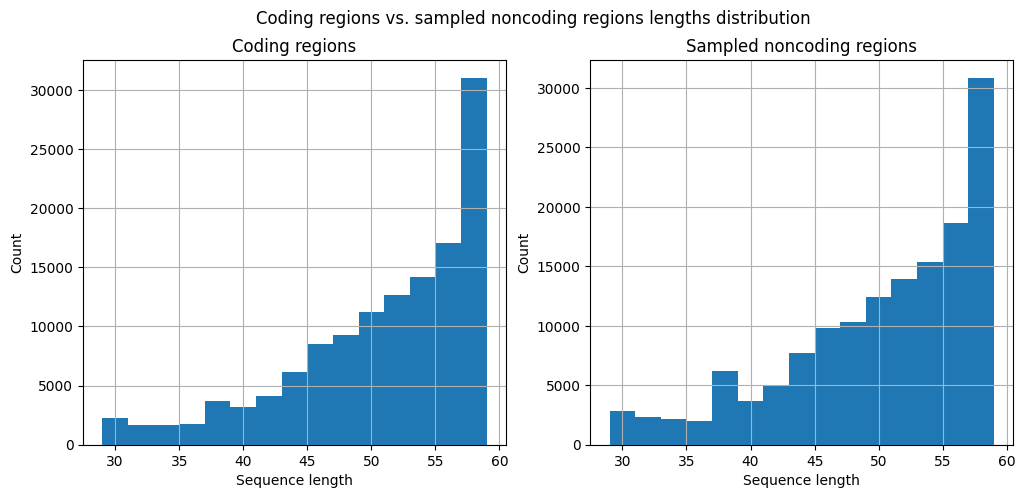

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Coding regions vs. sampled noncoding regions lengths distribution')
axes[0].set_title('Coding regions')
axes[1].set_title('Sampled noncoding regions')

axes[0].set_xlabel('Sequence length')
axes[0].set_ylabel('Count')

axes[1].set_xlabel('Sequence length')
axes[1].set_ylabel('Count')
# plt.xlabel('Count')
# plt.ylabel('Protein sequence length')

pd.Series(coding_region_lengths).hist(bins=15, ax=axes[0])
pd.Series(noncoding_region_lengths).hist(bins=15, ax=axes[1])
plt.show()

# fig.savefig('length_distribution.jpg')

# 10 fold cross validation

### loading all embeddings 

In [26]:
#getting train and test folders:
MAX_FOLD = 10
post_processed_data_PATH = 'post_processed_data'
all_genomes = os.listdir(post_processed_data_PATH)
all_genomes.remove('.DS_Store')


def retrieve_train_test_folders(genomes, hold_out_index):
    num_genomes = len(genomes)
    if hold_out_index == MAX_FOLD - 1:
        test_split = genomes[int((num_genomes//10) * hold_out_index): ]
        train_split = list(set(genomes) - set(test_split))
        assert len(train_split) + len(test_split) == num_genomes, "numbers do not match up!"
        return train_split, test_split
    test_split = genomes[int((num_genomes//10) * hold_out_index): int(num_genomes//10 * (hold_out_index + 1))]
    train_split = list(set(genomes) - set(test_split))
    assert len(train_split) + len(test_split) == num_genomes, "numbers do not match up!"
    return train_split, test_split
    
train_genomes, test_genomes = retrieve_train_test_folders(all_genomes, 0)


In [27]:
random.seed(5)
torch.manual_seed(5)
def load_data(genomes):
    all_x = np.array([])
    all_y = np.array([])

    random.seed(5)
    torch.manual_seed(5)
    for genome in genomes:
        
        positive_indices = np.array(positive_filtered_genes_indices[genome]) 
        negative_indices = np.array(negative_filtered_genes_indices[genome])

        if positive_indices.shape[0] != 0:
            genome_train_coding_embeddings = torch.load('post_processed_data/' + genome + '/coding_train_emb/train_mean.pt')
            genome_train_coding_labels = np.ones(genome_train_coding_embeddings.shape[0])[positive_indices]
            genome_train_coding_embeddings = genome_train_coding_embeddings[positive_indices]
            assert genome_train_coding_embeddings.shape[0] == len(positive_indices)

        if negative_indices.shape[0] != 0:
            genome_train_noncoding_embeddings = torch.load('post_processed_data/' + genome + '/noncoding_test_emb/train_mean.pt')
            genome_train_noncoding_labels = np.zeros(genome_train_noncoding_embeddings.shape[0])[negative_indices]
            genome_train_noncoding_embeddings = genome_train_noncoding_embeddings[negative_indices]
            assert genome_train_noncoding_embeddings.shape[0] == len(negative_indices)

        if all_x.shape[0] == 0:
            all_x = genome_train_coding_embeddings
            all_y = genome_train_coding_labels
            all_x = np.concatenate((all_x, genome_train_noncoding_embeddings), axis=0)
            all_y = np.concatenate((all_y, genome_train_noncoding_labels), axis=0)
            continue

        if positive_indices.shape[0] != 0:
            all_x = np.concatenate((all_x, genome_train_coding_embeddings), axis=0)
            all_y = np.concatenate((all_y, genome_train_coding_labels), axis=0)
        
        if negative_indices.shape[0] != 0:
            all_x = np.concatenate((all_x, genome_train_noncoding_embeddings), axis=0)
            all_y = np.concatenate((all_y, genome_train_noncoding_labels), axis=0)
    return all_x, all_y


In [32]:
all_data_folds_embs, all_data_folds_labels = [], []
MAX_FOLD = 10
for i in range(0, MAX_FOLD, 1):
    train_split, test_split = retrieve_train_test_folders(genomes, i)
    embs, labels = load_data(test_split)
    all_data_folds_embs.append(embs)
    all_data_folds_labels.append(labels)
    

Note that after applying filters, some of the genomes have no coding regions or noncoding regions

In [33]:
#sanity check that the dimension of the loaded data is equal to the dimension of the indices in the dictionary
assert np.vstack(all_data_folds_embs).shape[0] == len(flatten(positive_filtered_genes.values())) + len(flatten(negative_filtered_genes.values()))


In [30]:
empty_positive_genomes = []
for genome in genomes:
    if not positive_filtered_genes_indices[genome]:
        empty_positive_genomes.append(genome)
        print(genome)
        print('none!')
    

GCF_018406645.1_ASM1840664v1
none!
GCF_017896245.1_ASM1789624v1
none!
GCF_002850495.1_ASM285049v1
none!
GCF_018467135.1_ASM1846713v1
none!
GCF_011455875.1_ASM1145587v1
none!
GCF_002804025.1_ASM280402v1
none!


In [31]:
empty_negative_genomes = []
for genome in genomes:
    if not negative_filtered_genes_indices[genome]:
        empty_negative_genomes.append(genome)
        print(genome)
        print('none!')

GCF_000287275.1_ASM28727v1
none!
GCF_001447915.1_ASM144791v1
none!


## training clasifier

In [37]:
#loading classifier:
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

class Net1(nn.Module):
  def __init__(self,input_shape):
    super(Net1,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,128)
    self.fc4 = nn.Linear(128,64)
    self.fc5 = nn.Linear(64,32)
    self.fc6 = nn.Linear(32,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    torch.nn.init.xavier_uniform_(self.fc4.weight)
    torch.nn.init.xavier_uniform_(self.fc5.weight)
    torch.nn.init.xavier_uniform_(self.fc6.weight)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.sigmoid(self.fc6(x))
    return x

class Net3(nn.Module):
  def __init__(self,input_shape):
    super(Net3,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    
  def forward(self,x):
    x = torch.sigmoid(self.fc1(x))
    return x

class Net4(nn.Module):
  def __init__(self,input_shape):
    super(Net4,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,128)
    self.fc2 = nn.Linear(128,256)
    self.fc3 = nn.Linear(256,512)
    self.fc4 = nn.Linear(512,256)
    self.fc5 = nn.Linear(256,128)
    self.fc6 = nn.Linear(128,64)
    self.fc7 = nn.Linear(64,32)
    self.fc8 = nn.Linear(32,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    torch.nn.init.xavier_uniform_(self.fc4.weight)
    torch.nn.init.xavier_uniform_(self.fc5.weight)
    torch.nn.init.xavier_uniform_(self.fc6.weight)
    torch.nn.init.xavier_uniform_(self.fc7.weight)
    torch.nn.init.xavier_uniform_(self.fc8.weight)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    x = torch.sigmoid(self.fc8(x))
    return x

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

In [38]:
def create_train_test_data(all_data_folds_embs, all_data_folds_labels, fold):
    test_split = [fold]
    train_split = list(set(list(range(10))) - set([fold]))
    train_x = np.vstack([all_data_folds_embs[i] for i in train_split])
    train_y = np.concatenate([all_data_folds_labels[i] for i in train_split])
    test_x = np.vstack([all_data_folds_embs[i] for i in test_split])
    test_y = np.concatenate([all_data_folds_labels[i] for i in test_split])
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, 0)

#checking dimensions:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
    

(245544, 1280)
(245544,)
(26359, 1280)
(26359,)


In [39]:
#randomly shuffling train_x, train_y and their corresponding labels
random.seed(5)
torch.manual_seed(5)
training_indices = np.arange(train_x.shape[0])
test_indices = np.arange(test_x.shape[0])
np.random.shuffle(training_indices)
np.random.shuffle(test_indices)

In [40]:
train_x = train_x[training_indices]
train_y = train_y[training_indices]
test_x = test_x[test_indices]
test_y = test_y[test_indices]

In [41]:
random.seed(5)
torch.manual_seed(5)
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length
trainset = dataset(train_x, train_y)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

In [42]:
#hyper parameters
random.seed(5)
torch.manual_seed(5)
learning_rate = 0.01
epochs = 300
# Model , Optimizer, Loss
ecoli_model = Net4(input_shape=train_x.shape[1])
optimizer = torch.optim.SGD(ecoli_model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [ ]:
#forward loop
random.seed(5)
torch.manual_seed(5)
losses = []
accur = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainloader):
    
    #calculate output
    output = ecoli_model(x_train)
 
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
 
    #accuracy
    predicted = ecoli_model(torch.tensor(x_train,dtype=torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == np.array(y_train)).mean()
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%50 == 0:
    losses.append(loss)
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

# Run 10-fold cross validation

In [708]:
for epoch in range(0, 10, 1):
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, epoch)
    
    random.seed(5)
    torch.manual_seed(5)
    training_indices = np.arange(train_x.shape[0])
    test_indices = np.arange(test_x.shape[0])
    np.random.shuffle(training_indices)
    np.random.shuffle(test_indices)
    
    train_x = train_x[training_indices]
    train_y = train_y[training_indices]
    test_x = test_x[test_indices]
    test_y = test_y[test_indices]
    
    trainset = dataset(train_x, train_y)
    #DataLoader
    trainloader = DataLoader(trainset,batch_size=64,shuffle=False)
    
    #hyper parameters
    random.seed(5)
    torch.manual_seed(5)
    learning_rate = 0.01
    epochs = 300
    # Model , Optimizer, Loss
    ecoli_model = Net1(input_shape=train_x.shape[1])
    optimizer = torch.optim.SGD(ecoli_model.parameters(),lr=learning_rate)
    loss_fn = nn.BCELoss()
    
    random.seed(5)
    torch.manual_seed(5)
    losses = []
    accur = []
    for i in range(epochs):
      for j,(x_train,y_train) in enumerate(trainloader):

        #calculate output
        output = ecoli_model(x_train)

        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))

        #accuracy
        predicted = ecoli_model(torch.tensor(x_train,dtype=torch.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == np.array(y_train)).mean()
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      if i%50 == 0:
        losses.append(loss)
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))
    
    #saving model
    PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_" + str(epoch) + "_genomes.pt"
    torch.save(ecoli_model, PATH)
    
    

/Users/tonytu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0	loss : 0.17696475982666016	 accuracy : 0.95
epoch 50	loss : 0.14576508104801178	 accuracy : 0.925
epoch 100	loss : 0.13810546696186066	 accuracy : 0.925
epoch 150	loss : 0.1344241350889206	 accuracy : 0.95
epoch 200	loss : 0.1285872459411621	 accuracy : 0.95
epoch 250	loss : 0.11938326060771942	 accuracy : 0.95
epoch 0	loss : 0.24542240798473358	 accuracy : 0.8727272727272727
epoch 50	loss : 0.16304725408554077	 accuracy : 0.9272727272727272
epoch 100	loss : 0.1430915892124176	 accuracy : 0.9272727272727272
epoch 150	loss : 0.14132927358150482	 accuracy : 0.9454545454545454
epoch 200	loss : 0.13264790177345276	 accuracy : 0.9454545454545454
epoch 250	loss : 0.10950611531734467	 accuracy : 0.9818181818181818
epoch 0	loss : 0.06013019010424614	 accuracy : 0.95
epoch 50	loss : 0.03936905413866043	 accuracy : 1.0
epoch 100	loss : 0.03182206302881241	 accuracy : 1.0
epoch 150	loss : 0.03195275738835335	 accuracy : 1.0
epoch 200	loss : 0.03518430143594742	 accuracy : 1.0
epoch 250	lo

## evaluating model performance (aggregate)

In [316]:
accuracies, precisions, recalls, F1s = [], [], [], []
for i in range(10):
    print("fold " + str(i))
    # PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_models_with_42_held_out/six_layer_4246_genomes.pt"
    PATH = "final_ten_fold_cross_validation_models/six_layer_fold_" + str(i) + "_genomes.pt"
#     PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/all_available_data_final_ten_fold_cross_validation_models/six_layer_fold_" + str(i) + "_genomes.pt"
    ecoli_model = torch.load(PATH)
    ecoli_model.eval()
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, i)
    test_output_raw = ecoli_model(torch.Tensor(test_x))
    test_output = test_output_raw.round()
    accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(f1)
    print('\n')
    

fold 0
total samples: 26359
TP: 11295
FP: 593
TN: 13380
FN: 1091
accuracy: 0.936112902613908
precision: 0.9501177658142664
recall: 0.9119166801227192
F1: 0.9306253604679905


fold 1
total samples: 28136
TP: 12162
FP: 900
TN: 13976
FN: 1098
accuracy: 0.9289877736707421
precision: 0.9310978410656867
recall: 0.9171945701357466
F1: 0.9240939138363347


fold 2
total samples: 30155
TP: 13216
FP: 1047
TN: 14780
FN: 1112
accuracy: 0.9284032498756425
precision: 0.9265932833204795
recall: 0.9223897264098269
F1: 0.9244867265922843


fold 3
total samples: 27793
TP: 12172
FP: 656
TN: 13928
FN: 1037
accuracy: 0.9390853812110963
precision: 0.9488618646710321
recall: 0.9214929214929215
F1: 0.9349771479049045


fold 4
total samples: 26517
TP: 11761
FP: 863
TN: 13014
FN: 879
accuracy: 0.9343062940754987
precision: 0.9316381495564005
recall: 0.9304588607594937
F1: 0.9310481317289423


fold 5
total samples: 27544
TP: 12336
FP: 1063
TN: 13546
FN: 599
accuracy: 0.9396601800755155
precision: 0.92066572132248

In [318]:
accuracies, precisions, recalls, F1s = [], [], [], []
for i in range(10):
    print("fold " + str(i))
    # PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_models_with_42_held_out/six_layer_4246_genomes.pt"
#     PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_" + str(i) + "_genomes.pt"
    PATH = "all_available_data_final_ten_fold_cross_validation_models/six_layer_fold_" + str(i) + "_genomes.pt"
    ecoli_model = torch.load(PATH)
    ecoli_model.eval()
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, i)
    test_output_raw = ecoli_model(torch.Tensor(test_x))
    test_output = test_output_raw.round()
    accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(f1)
    print('\n')
    

fold 0
total samples: 26359
TP: 9839
FP: 190
TN: 13783
FN: 2547
accuracy: 0.8961644978944573
precision: 0.981054940672051
recall: 0.7943646051994186
F1: 0.8778942672317644


fold 1
total samples: 28136
TP: 10183
FP: 252
TN: 14624
FN: 3077
accuracy: 0.8816818311060562
precision: 0.9758505031145185
recall: 0.767948717948718
F1: 0.8595062249419709


fold 2
total samples: 30155
TP: 11165
FP: 295
TN: 15532
FN: 3163
accuracy: 0.8853258166141602
precision: 0.9742582897033158
recall: 0.7792434394193188
F1: 0.8659066232356134


fold 3
total samples: 27793
TP: 10764
FP: 271
TN: 14313
FN: 2445
accuracy: 0.9022775519015579
precision: 0.9754417761667422
recall: 0.8148989325459913
F1: 0.8879722818016829


fold 4
total samples: 26517
TP: 10078
FP: 204
TN: 13673
FN: 2562
accuracy: 0.8956895576422672
precision: 0.9801595020424042
recall: 0.7973101265822785
F1: 0.8793299014047641


fold 5
total samples: 27544
TP: 10763
FP: 232
TN: 14377
FN: 2172
accuracy: 0.9127214638396747
precision: 0.9788994997726239

In [319]:
print(np.mean(accuracies))
print(np.mean(precisions))
print(np.mean(recalls))
print(np.mean(F1s))

print('\n')
print(np.std(accuracies))
print(np.std(precisions))
print(np.std(recalls))
print(np.std(F1s))

0.8965642936234296
0.9785014626767857
0.7988488283325441
0.8793751432546267


0.01104675112425346
0.003257464032761391
0.02457563668818191
0.014371096748860793


In [130]:
test_output_raw = ecoli_model(torch.Tensor(test_x))
test_output = test_output_raw.round()

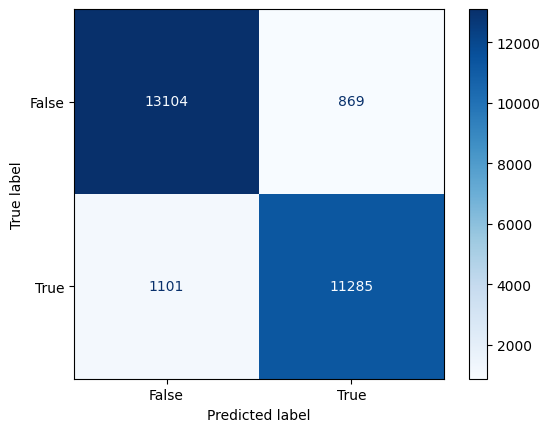

In [131]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(list(test_y), list(test_output.detach().numpy()))
# confusion_matrix = metrics.confusion_matrix(list(test_y), list(a))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# cm_display.set_ticklabels_format("d")
# np.set_printoptions(suppress=True) # disable scientific notation
cm_display.plot(cmap="Blues", values_format='')
plt.show()

In [37]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    print("total samples: " + str(len(y_actual)))
    print("TP: " + str(TP))
    print("FP: " + str(FP))
    print("TN: " + str(TN))
    print("FN: " + str(FN))
    accuracy = accuracy_score(y_actual, y_hat)
    precision = precision_score(y_actual, y_hat)
    recall = recall_score(y_actual, y_hat)
    f1 = f1_score(y_actual, y_hat)
    print("accuracy: " + str(accuracy))
    print("precision: " + str(precision))
    print("recall: " + str(recall))
    print("F1: " + str(f1))
    return accuracy, precision, recall, f1

In [133]:
accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))

total samples: 26359
TP: 11285
FP: 869
TN: 13104
FN: 1101
accuracy: 0.9252627186160325
precision: 0.9285009050518348
recall: 0.9111093169707735
F1: 0.9197229013854931


# evaluating genome by genome

In [38]:
random.seed(5)
torch.manual_seed(5)
accuracies, precisions, recalls, F1s = [], [], [], []

def evaluate_by_genome(genomes, find_TP_index = False):
    PATH = "final_ten_fold_cross_validation_models/six_layer_fold_0_genomes.pt"
    ecoli_model = torch.load(PATH)
    ecoli_model.eval()

    random.seed(5)
    torch.manual_seed(5)
    for genome in genomes:
        print(genome)
        test_x = np.array([])
        test_y = np.array([])
        positive_indices = np.array(positive_filtered_genes_indices[genome]) 
        negative_indices = np.array(negative_filtered_genes_indices[genome])
        if positive_indices.shape[0] == 0 or negative_indices.shape[0] == 0:
            continue

        genome_train_coding_embeddings = torch.load('post_processed_data/' + genome + '/coding_train_emb/train_mean.pt')
        genome_train_coding_labels = np.ones(genome_train_coding_embeddings.shape[0])[positive_indices]
        genome_train_coding_embeddings = genome_train_coding_embeddings[positive_indices]
        assert genome_train_coding_embeddings.shape[0] == len(positive_indices)

        genome_train_noncoding_embeddings = torch.load('post_processed_data/' + genome + '/noncoding_test_emb/train_mean.pt')
        genome_train_noncoding_labels = np.zeros(genome_train_noncoding_embeddings.shape[0])[negative_indices]
        genome_train_noncoding_embeddings = genome_train_noncoding_embeddings[negative_indices]
        assert genome_train_noncoding_embeddings.shape[0] == len(negative_indices)
        
        if test_x.shape[0] == 0:
            test_x = genome_train_coding_embeddings
            test_y = genome_train_coding_labels
            test_x = np.concatenate((test_x, genome_train_noncoding_embeddings), axis=0)
            test_y = np.concatenate((test_y, genome_train_noncoding_labels), axis=0)

        test_output_raw = ecoli_model(torch.Tensor(test_x))
        test_output = test_output_raw.round()
        
        if find_TP_index:
            print(len(test_y))
            print(sum(test_y))
            print(len(test_y) - sum(test_y))
            print([i - int(sum(test_y)) for i in range(len(test_output)) if test_output[i] == 1 and test_y[i] == 0])
    
        accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        F1s.append(f1)

evaluate_by_genome(genomes[:100], True)
        

GCF_000283915.1_ASM28391v1
98
48.0
50.0
[9, 21]
total samples: 98
TP: 27
FP: 2
TN: 48
FN: 21
accuracy: 0.7653061224489796
precision: 0.9310344827586207
recall: 0.5625
F1: 0.7012987012987013
GCF_002056795.1_ASM205679v1
66
33.0
33.0
[3, 6, 10, 13, 25]
total samples: 66
TP: 32
FP: 5
TN: 28
FN: 1
accuracy: 0.9090909090909091
precision: 0.8648648648648649
recall: 0.9696969696969697
F1: 0.9142857142857143
GCF_009734425.1_ASM973442v1
42
20.0
22.0
[8]
total samples: 42
TP: 20
FP: 1
TN: 21
FN: 0
accuracy: 0.9761904761904762
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_003097575.1_ASM309757v1
31
16.0
15.0
[]
total samples: 31
TP: 14
FP: 0
TN: 15
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_900476035.1_53694_C01
36
16.0
20.0
[]
total samples: 36
TP: 15
FP: 0
TN: 20
FN: 1
accuracy: 0.9722222222222222
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_007750855.1_ASM775085v1
30
15.0
15.0
[0]
total samples: 30
TP: 14
FP: 1
TN:

accuracy: 0.9473684210526315
precision: 0.9444444444444444
recall: 0.9444444444444444
F1: 0.9444444444444444
GCF_000953655.1_LHA
50
25.0
25.0
[]
total samples: 50
TP: 21
FP: 0
TN: 25
FN: 4
accuracy: 0.92
precision: 1.0
recall: 0.84
F1: 0.9130434782608696
GCF_000828915.1_ASM82891v1
23
10.0
13.0
[]
total samples: 23
TP: 10
FP: 0
TN: 13
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_014217335.1_ASM1421733v1
24
12.0
12.0
[]
total samples: 24
TP: 12
FP: 0
TN: 12
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_002243665.1_ASM224366v1
185
81.0
104.0
[28, 82, 87]
total samples: 185
TP: 73
FP: 3
TN: 101
FN: 8
accuracy: 0.9405405405405406
precision: 0.9605263157894737
recall: 0.9012345679012346
F1: 0.9299363057324841
GCF_003265305.2_ASM326530v2
16
8.0
8.0
[]
total samples: 16
TP: 8
FP: 0
TN: 8
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003851555.1_ASM385155v1
86
37.0
49.0
[13, 36, 39, 48]
total samples: 86
TP: 35
FP: 4
TN: 45
FN: 2
accuracy: 0.9302325581395

In [826]:
print(np.mean(accuracies), np.std(accuracies))
print(np.mean(precisions), np.std(precisions))
print(np.mean(recalls), np.std(recalls))
print(np.mean(F1s), np.std(F1s))



0.807382181505154 0.08080859075054792
0.9557485970819304 0.034604080809111544
0.6634324374849281 0.2134564478055572
0.7589389564582983 0.14515720502173257


## random baseline

In [747]:
def generate_random_vector(x):
    vector = []
    for _ in range(x):
        element = random.choice([0, 1])
        vector.append(element)
    return vector

random_accuracies, random_precisions, random_recalls, random_f1s = [], [], [], [] 

random.seed(5)
#since data is not completely balanced, we need to add a baseline which predicts labels randomly. 
for i in range(10):
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, i)
    print(train_x.shape)
    print(test_x.shape)
    random_vector = generate_random_vector(len(test_y))
    random_accuracy, random_precision, random_recall, random_f1 = perf_measure(list(test_y), list(random_vector))
    random_recalls.append(random_recall)
    random_accuracies.append(random_accuracy)
    random_precisions.append(random_precision)
    random_f1s.append(random_f1)
    


(245544, 1280)
(26359, 1280)
total samples: 26359
TP: 6223
FP: 7078
TN: 6895
FN: 6163
accuracy: 0.49766683106339393
precision: 0.46785955943162166
recall: 0.5024220894558372
F1: 0.4845252462335033
(243767, 1280)
(28136, 1280)
total samples: 28136
TP: 6633
FP: 7411
TN: 7465
FN: 6627
accuracy: 0.5010662496445835
precision: 0.47230133864995727
recall: 0.5002262443438914
F1: 0.48586287723410493
(241748, 1280)
(30155, 1280)
total samples: 30155
TP: 7217
FP: 7974
TN: 7853
FN: 7111
accuracy: 0.49975128502735866
precision: 0.47508393127509707
recall: 0.5036990508096035
F1: 0.48897320369931224
(244110, 1280)
(27793, 1280)
total samples: 27793
TP: 6589
FP: 7258
TN: 7326
FN: 6620
accuracy: 0.5006656352318929
precision: 0.47584314291904384
recall: 0.49882655765008704
F1: 0.4870638675340035
(245386, 1280)
(26517, 1280)
total samples: 26517
TP: 6242
FP: 6990
TN: 6887
FN: 6398
accuracy: 0.49511634046083647
precision: 0.47173518742442566
recall: 0.49382911392405066
F1: 0.4825293753865183
(244359, 1280

In [748]:
print(np.mean(random_accuracies), np.std(random_accuracies))
print(np.mean(random_precisions), np.std(random_precisions))
print(np.mean(random_recalls), np.std(random_recalls))
print(np.mean(random_f1s), np.std(random_f1s))

0.49938771095139967 0.002909228019437151
0.47235386543608826 0.0024551607781829036
0.501439262100752 0.0036040333950898454
0.4864537041303881 0.0022595000503375763
